# Colossus tutorial: Power spectrum, variance, correlation function

Welcome to the Colossus power spectrum tutorial.

In [1]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import copy
import numpy as np
%matplotlib inline

First we initialize a cosmology object. Since we will be playing with different versions of power spectra, we do not wish to write the results to disk for the next run and thus set persistence to read-only (which we will need below).

In [2]:
from colossus.cosmology import cosmology

cosmo = cosmology.setCosmology('planck18', persistence = 'r')

## Power spectrum from fitting functions

Colossus is geared toward calculations related to the evolution of structure in the universe and this focus is reflected in the cosmology module. We assume that the linear over- and underdensity field is given by a Gaussian random field which is unambiguously described by its power spectrum $P(k)$. By default, Colossus evaluates the matter power spectrum using the approximation of [Eisenstein & Hu 1998](http://adsabs.harvard.edu/abs/1998ApJ...496..605E), but the user can also pass a tabulated power spectrum (e.g., computed using CAMB). 

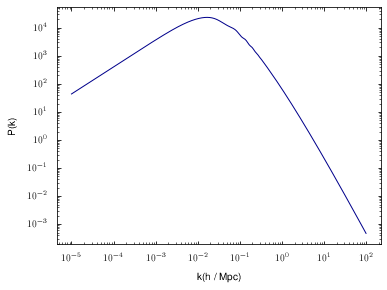

In [3]:
k = 10**np.linspace(-5.0, 2.0, 500)
Pk = cosmo.matterPowerSpectrum(k)

plt.figure()
plt.loglog()
plt.xlabel('k(h / Mpc)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-');

It is a little hard to discern features in the power spectrum with this many orders of magnitude on the plot. As the functions discussed above, the `matterPowerSpectrum()` function relies on interpolating splines and can return the derivative of the power spectrum, highlighting the BAO wiggles:

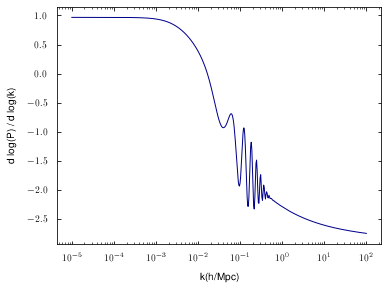

In [4]:
Pk_deriv = cosmo.matterPowerSpectrum(k, derivative = True)

plt.figure()
plt.xscale('log')
plt.xlabel('k(h/Mpc)')
plt.ylabel('d log(P) / d log(k)')
plt.plot(k, Pk_deriv, '-');

## Integral quantities: variance and correlation function

A number of important quantities are integrals over the power spectrum, for example the matter-matter correlation function:

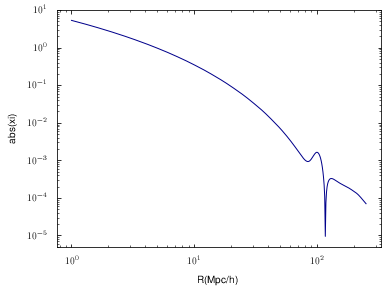

In [5]:
R = 10**np.linspace(0.0, 2.4, 500)
xi = cosmo.correlationFunction(R, 0.0)

plt.figure()
plt.loglog()
plt.xlabel('R(Mpc/h)')
plt.ylabel('abs(xi)')
plt.plot(R, np.abs(xi), '-');

...or the variance `sigma(R)`. The variance is defined for a particular filter function, three of which are implemented in colossus: a top-hat in real space, a Gaussian, and a sharp-k space filter. The tophat filter is most commonly used, e.g. when computing peak height (see [LSS module](https://bdiemer.bitbucket.io/colossus/lss.html)), and is the default in Colossus.

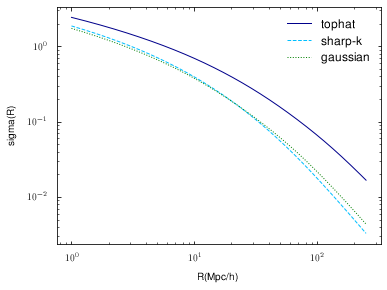

In [6]:
R = 10**np.arange(0,2.4,0.005)
sigma_tophat = cosmo.sigma(R, 0.0)
sigma_sharpk = cosmo.sigma(R, 0.0, filt = 'sharp-k')
sigma_gaussian = cosmo.sigma(R, 0.0, filt = 'gaussian')

plt.figure()
plt.loglog()
plt.xlabel('R(Mpc/h)')
plt.ylabel('sigma(R)')
plt.plot(R, sigma_tophat, '-', label = 'tophat')
plt.plot(R, sigma_sharpk, '--', label = 'sharp-k')
plt.plot(R, sigma_gaussian, ':', label = 'gaussian')
plt.legend();

You may notice that the first time you execute the functions the functions above, they can take up to a couple of seconds. That's because Colossus computes an interpolation table, saves it to disk, and loads it the next time the same cosmology is initiated. If, for some reason, this behavior is undesired, you can control it with the `interpolation` and `persistence` parameters to the constructor.

## User-defined power spectrum

Colossus can accept a user-defined power spectrum stored in a file, which needs to contain two columns corresponding to $\log_{10}(k)$ (in comoving $h / {\rm Mpc}$) and $\log_{10}(P)$ (in $({\rm Mpc}/h)^3$). We need to give this "model" a unique name, and we need to make sure to not request wavenumbers outside the range of the table. The table used in the following example was computed using CAMB (and the same parameters as in the planck18 cosmology).

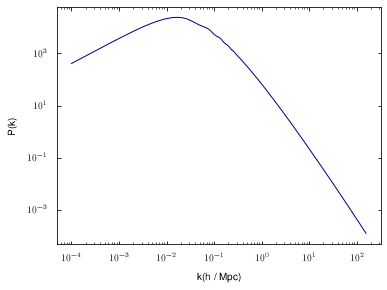

In [7]:
from colossus.utils import utilities

file_path = utilities.getCodeDir()[:-9] + '/docs/source/_data/power_spectrum.txt'
ps_args_table = dict(model = 'mytable', path = file_path)

k_table = 10**np.linspace(-4.0, 2.2, 200)
P_table = cosmo.matterPowerSpectrum(k_table, **ps_args_table)

plt.figure()
plt.loglog()
plt.xlabel('k(h / Mpc)')
plt.ylabel('P(k)')
plt.plot(k_table, P_table, '-');

For comparison, we can compute and plot the difference to the Eisenstein & Hu approximation:

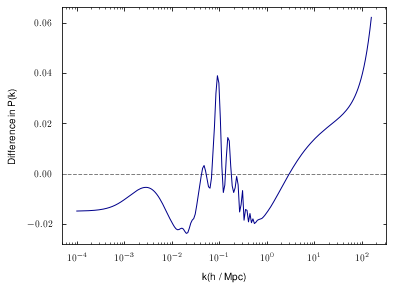

In [8]:
P_eh98 = cosmo.matterPowerSpectrum(k_table, model = 'eisenstein98')

plt.figure()
plt.xscale('log')
plt.xlabel('k(h / Mpc)')
plt.ylabel('Difference in P(k)')
plt.axhline(0.0, ls = '--', color = 'gray')
plt.plot(k_table, P_eh98 / P_table - 1.0, '-');

We note how the Eisenstein & Hu model diverges from the Boltzmann solver at high k because the baryon pressure is not taken into account. We can use the "table" model in any function that uses the power spectrum. For example, we might wonder how the different power spectra affect peak height:

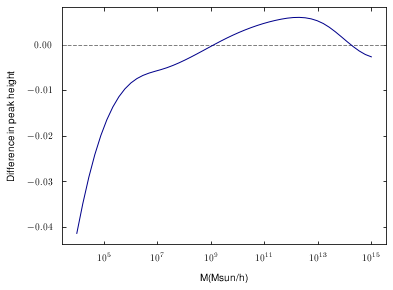

In [9]:
from colossus.lss import peaks

M = 10**np.linspace(4.0, 15.0, 50)
z = 0.0

nu_table = peaks.peakHeight(M, z, ps_args = ps_args_table)
nu_eh98 = peaks.peakHeight(M, z, ps_args = dict(model = 'eisenstein98'))

plt.figure()
plt.xscale('log')
plt.xlabel('M(Msun/h)')
plt.ylabel('Difference in peak height')
plt.axhline(0.0, ls = '--', color = 'gray')
plt.plot(M, nu_eh98 / nu_table - 1.0, '-');

The difference is small but becomes noticable at very small halo masses (note that the variance is overestimated by the fitting function, which leads to an underestimate of the peak height).

## Power spectrum from CAMB

Instead of manually saving power spectra to a table, Colossus can interface with the CAMB code directly. For this purpose, CAMB and its python wrapper need to be installed, e.g., with

pip install camb

If CAMB is not installed on your machine, the rest of this tutorial will not work. Let's make the same comparison plot as above, but using the CAMB interface:

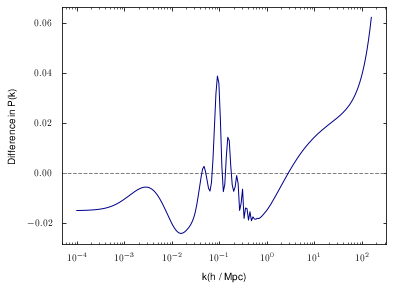

In [10]:
k = 10**np.linspace(-4.0, 2.2, 200)
P_eh98 = cosmo.matterPowerSpectrum(k, model = 'eisenstein98')
P_camb = cosmo.matterPowerSpectrum(k, model = 'camb')

plt.figure()
plt.xscale('log')
plt.xlabel('k(h / Mpc)')
plt.ylabel('Difference in P(k)')
plt.axhline(0.0, ls = '--', color = 'gray')
plt.plot(k, P_eh98 / P_camb - 1.0, '-');

You might notice that the computation takes a few seconds the first time it is executed. That's because CAMB performs a much more involved calculation than the fitting function. As expected, the result is very similar. We can pass numerous arguments to the CAMB function, some of which are parsed by Colossus and some of which are simply passed to the CAMB initialization routine. For example, Colossus lets the user change the upper k limit (which significantly affects the execution speed) and whether the total, CDM, or baryon power spectrum is returned:

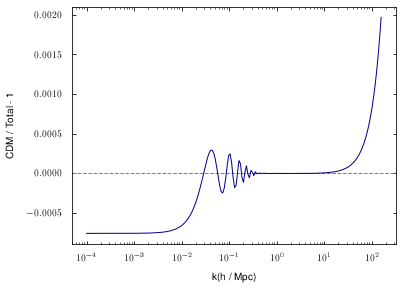

In [11]:
k = 10**np.linspace(-4.0, 2.2, 200)
P_tot = cosmo.matterPowerSpectrum(k, model = 'camb')
P_cdm = cosmo.matterPowerSpectrum(k, model = 'camb', ps_type = 'cdm')

plt.figure()
plt.xscale('log')
plt.xlabel('k(h / Mpc)')
plt.ylabel('CDM / Total - 1')
plt.axhline(0.0, ls = '--', color = 'gray')
plt.plot(k, P_cdm / P_tot - 1.0, '-');

To see the effect of limiting the k-range, we can consider the variance:

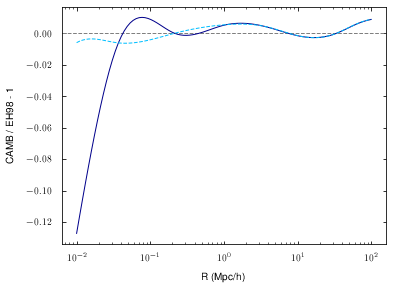

In [12]:
R = 10**np.linspace(-2.0, 2.0, 100)

sigma_eh98 = cosmo.sigma(R, ps_args = dict(model = 'eisenstein98'))
sigma_k2 = cosmo.sigma(R, ps_args = dict(model = 'camb', kmax = 1E2))
sigma_k3 = cosmo.sigma(R, ps_args = dict(model = 'camb', kmax = 1E3))

plt.figure()
plt.xscale('log')
plt.xlabel('R (Mpc/h)')
plt.ylabel('CAMB / EH98 - 1')
plt.axhline(0.0, ls = '--', color = 'gray')
plt.plot(R, sigma_k2 / sigma_eh98 - 1.0, '-')
plt.plot(R, sigma_k3 / sigma_eh98 - 1.0, '--');

On large scales, the EH98 approximation is close to the more accurate CAMB result. On small scales, the CAMB spectrum that is cut off (solid line) leads to a quickly falling variance. To compute the variance on such small scales, it would be better to use the EH98 function or to set kmax to a higher value (dashed line), but this leads to a longer execution time). Note that Colossus automatically keeps track of the different spectra that arise

We can also play with much more "adventurous" parameters in CAMB. For example, we can turn on the reionization module and compare the resulting power spectra. Here we need to be careful: Colossus cannot keep track of all possible combinations of keyword arguments. It's also important to make sure that the cosmology with the unusual CAMB run is not stored for future runs!

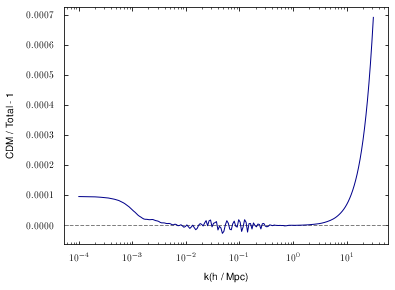

In [14]:
import camb

k = 10**np.linspace(-4.0, 1.5, 200)

P_def = cosmo.matterPowerSpectrum(k, model = 'camb')

cosmo2 = cosmology.setCosmology('planck18', persistence = 'r')
Reion = camb.reionization.TanhReionization(Reionization = True)
P_reion = cosmo2.matterPowerSpectrum(k, model = 'camb', Reion = Reion)

plt.figure()
plt.xscale('log')
plt.xlabel('k(h / Mpc)')
plt.ylabel('CDM / Total - 1')
plt.axhline(0.0, ls = '--', color = 'gray')
plt.plot(k, P_reion / P_def - 1.0, '-');